# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 2: Tipping points and the Greenland ice sheet

Modelling the interplay between global temperatures and albedo affect to predict the melting of the greenland icesheet.


### Modelling Assumptions

- parabolic ice sheet cross section

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

Solver succeeded!
Solution shape: (5, 1000)


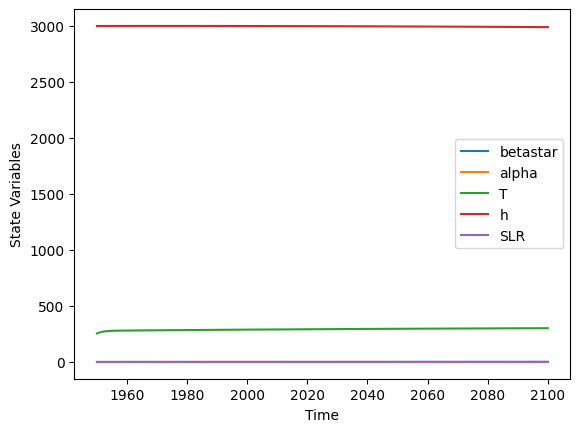

In [63]:
def GrIS_melt(t, state_var, params):
    # Extract state variables
    betastar, alpha, T, h, SLR = state_var

    # Adjust time reference
    t_adj = t - params["start_year"]

    # Define betastar ODE
    dbetastar = params["G"] * (
        params["kappa"] * (params["gamma"] * t_adj + params["E_0"])
        - (1 / params["t_CO2"]) * ((betastar / params["G"]) - params["rho_0"])
    )

    # Define alpha ODE
    # dalpha = (0.9 * (h / params["h_0"])**2)
    dalpha = ((2* params["alpha_rate"]* h / params["h_0"]**2) * 
              (params["P"] - (params["r"] * (params["T_0"] + T)) / (h + params["h_f"]) - params["F"] * h)
    )

    # Define temperature ODE
    # dT = (1 / params["C"]) * (
    #     (1 - alpha) * params["Q"]
    #     - (1 - (params["beta"] + betastar)) * params["sigma"] * np.pow(T,4)
    # )
    T_safe = np.clip(T, 1e-3, None)  # Prevent T from going negative
    # dT = (1 / params["C"]) * ((1 - alpha) * params["Q"] - (1 - (params["beta"] + betastar)) * params["sigma"] * T_safe**4)
    dT = (1 / params["C"]) * ((1 - alpha) * params["Q"] - np.clip((1 - (params["beta"] + betastar)), 0.1, 1) * params["sigma"] * T_safe**4)


    # Define height ODE
    # dh = params["P"] - ((params["r"] * (params["T_0"] + T)) / (h + params["h_f"])) - params["F"] * h
    # dh = params["P"] - (params["r"] * (T)) / (h + params["h_f"]) - params["F"] * h
    h_safe = np.clip(h, 500, None)  # Ensure h doesn't go too low
    dh = params["P"] - ((params["r"] * (params["T_0"] + T)) / (h_safe + params["h_f"])) - params["F"] * h_safe


    # Define SLR ODE (Fix: Prevent division by zero)
    h_safe = max(h, 1e-10)
    dSLR = (params["V_GrIS"] - (h_safe / params["h_0"])**3 * params["V_GrIS"]) / params["SA_o"]

    # print
    # print(f"T: {T}, betastar: {betastar}, alpha: {alpha}, dh: {dh}, dT: {dT}")


    return [dbetastar, dalpha, dT, dh, dSLR]

# Define initial conditions
state_var_0 = [0, 0.4, 254, 3000, 0]

# Define model parameters
params = {
    "G": 4e-6, # 3.12169312e-05,
    "kappa": 1e-7,
    "gamma": 1e-1,
    "start_year": 1950,
    "E_0": 5.2e9,
    "t_CO2": 100,
    "rho_0": 315,
    "alpha_rate": 0.3,
    "h_0": 3000,
    "C": 5,
    "Q": 340,
    "beta": 0.4,
    "sigma": 5.67e-8,
    "P": 4,
    "r": 37,
    "T_0": 254,
    "h_f": 2000,
    "F": 1e-5,
    "V_GrIS": 1.13144459419036e15,
    "SA_o": 3.618e14,
}

# Solve the system
t_span = (1950, 2100)  # Time range
t_eval = np.linspace(1950, 2100, 1000)

# Run the solver
# sol = solve_ivp(GrIS_melt, t_span, state_var_0, args=(params,), method="RK45", t_eval=t_eval)
sol = solve_ivp(GrIS_melt, t_span, state_var_0, args=(params,), method="RK45", t_eval=t_eval, max_step=0.5)


# Check if solver was successful
if not sol.success:
    print("Solver did not converge. Check for numerical issues.")
    print(f"Message: {sol.message}")
else:
    print("Solver succeeded!")

# Check the shape of the solution
print(f"Solution shape: {sol.y.shape}")

# Plot the results
plt.plot(sol.t, sol.y[0], label="betastar")
plt.plot(sol.t, sol.y[1], label="alpha")
plt.plot(sol.t, sol.y[2], label="T")
plt.plot(sol.t, sol.y[3], label="h")
plt.plot(sol.t, sol.y[4], label="SLR")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State Variables")
plt.show()
